In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

from torchvision.transforms import v2

In [2]:
# 데이터셋 표준화를 위한 기본정보 # 패치(반사패딩 추가해야함)
imgNet_val = {'mean' : [0.485, 0.456, 0.406], 'std' : [0.229, 0.224, 0.225]}
pad_factor = [0.01, 0.01, 0.09, 0.09] #left, top, right, bottom

# 이미지를 받아서 텐서 자료형으로 변환하는 함수
def preprocess_img(img_path, device, pad_factor, patch=1):
    assert int(patch ** 0.5) ** 2 == patch, "패치는 제곱수여야 함"

    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    img_shape = [height, width] #원본 이미지의 크기정보를 따로 저장

    #이미지를 패치로 나누기
    patches = []
    patch_size = []
    if patch != 1:
        patch_side = int(patch ** 0.5)
        patch_size = [height // patch_side, width // patch_side]
        for n in range(patch):
            i, j = divmod(n, patch_side) #몫, 나머지를 i, j로 활용
            patch_img = img.crop((j * patch_size[1], 
                                  i * patch_size[0], 
                                  (j + 1) * patch_size[1], 
                                  (i + 1) * patch_size[0]))
            patches.append(patch_img)
    else:
        patches.append(img)
        patch_size = [height, width]

    padding = [ # 비율에 따른 반사 패딩 값 계산
        int(patch_size[1] * pad_factor[0]),    # left
        int(patch_size[0] * pad_factor[1]),   # top
        int(patch_size[1] * pad_factor[2]),    # right
        int(patch_size[0] * pad_factor[3])    # bottom
    ]

    transformation = v2.Compose([
        v2.Pad(padding, padding_mode='reflect'), #반사패딩 설정

        v2.Resize((224, 224)), #[224, 224]로 리사이징
        v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
        v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 정규화
        v2.Normalize(mean=imgNet_val['mean'], std=imgNet_val['std']) #데이터셋 표준화
    ])

    # img_tensor = transformation(img).unsqueeze(0).to(device)
    # 각 패치별로 transformation을 적용 -> 텐서 자료형변환
    patch_tensors = [transformation(patch) for patch in patches]
    img_tensor = torch.stack(patch_tensors).to(device)
    # 이렇게 하면 img_tensor의 shape는 (batch_size=patch, 3, 224, 224)가 됨

    return img_tensor, img_shape

# 텐서 자료형의 이미지를 원복하는 함수
def deprocess_img(img_tensor, img_shape, pad_factor):
    tenser_size = img_tensor.shape[2:] #텐서 이미지의 H, W 추출
    # 이미지가 패치로 나눠어진 경우 해당 정보를 추출
    batch_size = img_tensor.size(0)
    patch_side = int(batch_size ** 0.5)
    patch_size = (img_shape[0] // patch_side, img_shape[1] // patch_side)

    crop_pad = [int(pad_factor[1] / (1+ pad_factor[1]+pad_factor[3]) * tenser_size[0]), #top
                int(pad_factor[0] / (1+ pad_factor[0]+pad_factor[2]) * tenser_size[1]), #left 
                int(1 / (1+ pad_factor[1]+pad_factor[3]) * tenser_size[0]),             #height
                int(1 / (1+ pad_factor[0]+pad_factor[2]) * tenser_size[1])              #width
    ]
    #반사 패딩 항목을 제거
    patches_tensor = [v2.functional.crop(img_tensor[i], crop_pad[0]+1, # top
                                                        crop_pad[1]+1, # left
                                                        crop_pad[2]+1, # height
                                                        crop_pad[3]+1) # width
                                    for i in range(batch_size)]

    #패치 텐서를 각 패치별 크기로 원복(리사이징)
    patches_tensor = [v2.functional.resize(patches_tensor[i], patch_size) for i in range(batch_size)]
    #np 자료형으로 변환
    patches_np = [patch_tensor.cpu().numpy().squeeze().transpose(1, 2, 0) for patch_tensor in patches_tensor]

    # 이미지에 표준화 되어 있던걸 원복
    patches_np = [(patch_np * np.array(imgNet_val['std']) + np.array(imgNet_val['mean'])) for patch_np in patches_np]
    patches_np = [np.clip(patch_np, 0, 1) for patch_np in patches_np]

    # 패치를 하나의 이미지로 결합
    rows = [np.concatenate(patches_np[i * patch_side:(i + 1) * patch_side], axis=1) for i in range(patch_side)]
    full_img = np.concatenate(rows, axis=0)
    img = (full_img * 255).astype(np.uint8)

    return img

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_path = '12345.jpg' #불러올 이미지의 경로

In [4]:
img_tensor, shape = preprocess_img(img_path, device, pad_factor, patch=25)

restore_img = deprocess_img(img_tensor, shape, pad_factor)

res_img = Image.fromarray(restore_img)
res_img.save("restore.jpg")

In [5]:
from torchvision.models import inception_v3, Inception_V3_Weights

backbone = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1).to(device)
backbone.eval() #모델을 평가모드로 전환

# 특정 모듈에 곱할 coefficieint를 {모듈 이름} : {coeff} 딕셔너리 형태로 저장
block_setting = {
    "Mixed_5d": 1.0,
    "Mixed_6a": 1.5,
    "Mixed_6e": 2.0,
    "Mixed_7a": 2.5,
}

In [6]:
# from DenseNet import DenseNet, DenseNet121, DenseNet169, DenseNet201, DenseNet161

# backbone = DenseNet121(pretrained=True).to(device)
# backbone.eval() #모델을 평가모드로 전환

# block_setting = {
#     # "dense_block1": 1,  # 55레이어
#     # "dense_block2": 1.5,  # 109레이어
#     "dense_block3": 2,  # 433레이어
#     "dense_block4": 2.5,  # 289레이어
#     "trans_block1": 1,  # 6 레이어
#     "trans_block2": 1.5,  # 6 레이어
#     # "trans_block3": 2.0,  # 6 레이어
#     "trans_block4": 2.5,  # 3 레이어
# }

In [7]:
class DeepDreamNet(nn.Module):
    def __init__(self, backbone, block_setting, device):
        super(DeepDreamNet, self).__init__()

        self.backbone = backbone.to(device) # backbone인스턴스화 + 디바이스지정
        self.block_setting = block_setting # 폭주시킬 블럭명 리스트 가져오기
        self.device = device # 모델이 위치한 디바이스 정보 저장
        self.outputs = {} #backbone의 캡쳐한 Feature out을 저장

        def hook_fn(moduls, input, output, layer_name):
            if layer_name not in self.outputs:
                # for block in self.block_setting : 사전 설정한 블럭세팅 리스트에서 요소 추출
                # if block in layer_name : 현재 '블럭 명'이 '레이어 이름'에 포함되었는지 확인
                # 포함되어 있으면 -> block_name에 리스트의 첫번째 값을 반환해 문자열 전송
                block_name = [block for block in self.block_setting if block in layer_name][0]

                if block_name not in self.outputs:
                    self.outputs[block_name] = {} #1차 디렉토리 생성
                # outputs를 2차 디렉토리화 -> value에 레이어의 feature_out을 저장
                self.outputs[block_name][layer_name] = output

        for name, module in self.backbone.named_modules():
            # 아래 조건문은 name이 block리스트에 있는
            # block 문자열을 포함하는지를 확인하는 코드
            # 여기서 name = 특정 레이어의 이름
            if any(block in name for block in self.block_setting):
                # print(f"찾은 블록의 이름: {name}")
                # print(f"해당 블록의 구성: {module}")
                self._register_hook(module, name, hook_fn)

    
    def _register_hook(self, module, layer_name, hook_fn):
        def hook(module, input, output):
            return hook_fn(module, input, output, layer_name)
        module.register_forward_hook(hook)

    
    def get_device(self): # DeepDreamNet의 디바이스 위치 확인하기
        return self.device
    
    def forward(self, x):
        _ = self.backbone(x)
        return self.outputs

In [8]:
# 설계한 DeepDreamNet를 받아서 인스턴스화
dream_net = DeepDreamNet(backbone, block_setting.keys(), device)

In [9]:
# 인스턴스화 한 dream_net에 데이터를 입력하여 출력물을 생성
img_tensor, shape = preprocess_img(img_path, device, pad_factor)
outputs = dream_net(img_tensor)

In [10]:
for block_name, layers in outputs.items():
    print(f"블럭이름: {block_name}, 블럭 내 캡쳐한 레이어 개수: {len(layers)}", end='\n\n')
    for layer, output in layers.items():
        layer_str = f" -레이어: {layer}".ljust(40)  # 레이어 이름을 40자로 맞춤
        print(f"{layer_str} 레이어 출력: {output.shape}")
    print(end='\n\n')

블럭이름: trans_block1, 블럭 내 캡쳐한 레이어 개수: 6

 -레이어: trans_blocks.trans_block1.tr_layer.0 레이어 출력: torch.Size([1, 256, 56, 56])
 -레이어: trans_blocks.trans_block1.tr_layer.1 레이어 출력: torch.Size([1, 256, 56, 56])
 -레이어: trans_blocks.trans_block1.tr_layer.2 레이어 출력: torch.Size([1, 128, 56, 56])
 -레이어: trans_blocks.trans_block1.tr_layer 레이어 출력: torch.Size([1, 128, 56, 56])
 -레이어: trans_blocks.trans_block1.ave_pool 레이어 출력: torch.Size([1, 128, 28, 28])
 -레이어: trans_blocks.trans_block1         레이어 출력: torch.Size([1, 128, 28, 28])


블럭이름: trans_block2, 블럭 내 캡쳐한 레이어 개수: 6

 -레이어: trans_blocks.trans_block2.tr_layer.0 레이어 출력: torch.Size([1, 512, 28, 28])
 -레이어: trans_blocks.trans_block2.tr_layer.1 레이어 출력: torch.Size([1, 512, 28, 28])
 -레이어: trans_blocks.trans_block2.tr_layer.2 레이어 출력: torch.Size([1, 256, 28, 28])
 -레이어: trans_blocks.trans_block2.tr_layer 레이어 출력: torch.Size([1, 256, 28, 28])
 -레이어: trans_blocks.trans_block2.ave_pool 레이어 출력: torch.Size([1, 256, 14, 14])
 -레이어: trans_blocks.trans_block2      

In [11]:
import torch.nn.functional as F

class DeepDream():
    def __init__(self, Net, block_setting, 
                 learning_rate, iterations, max_loss=None):
        self.net = Net
        self.block_setting = block_setting
        self.lr = learning_rate
        self.iter = iterations
        self.max_loss = max_loss

    def compute_loss(self, outputs):
        # outputs은 2차원 딕셔너리 -> value의 디바이스 위치 확인
        first_value = next(iter(next(iter(outputs.values())).values()))
        device = first_value.device
        #loss변수의 선언은 1차원(스칼라), grad추적가능, 디바이스 정보 받음
        loss = torch.zeros(1, requires_grad=True, device=device)
        
        for block_name, layers in outputs.items():
            # print(f"블럭이름: {block_name}, 블럭 내 캡쳐한 레이어 개수: {len(layers)}")
            if block_name in self.block_setting:
                coeff = self.block_setting[block_name] 
                #coeff를 곱할 레이어 out을 activation이라 재명기
                for layer_name, activation in layers.items():
                    # cropped_activation = activation[:, :, 2:-2, 2:-2]  # 가장자리를 제외한 활성화 값을 얻습니다.
                    layer_loss = coeff * F.mse_loss(activation, torch.zeros_like(activation))
                    #layer_loss = coeff * torch.mean(torch.square(activation)) 와 같은 연산
                    loss = loss + layer_loss  # in-place 연산을 피하기 위해 + 연산을 사용합니다.
        # 설계한 Loss Function은 Mean Square Error이다
        return loss
    
    def gradient_ascent_step(self, img_tensor):
        img_tensor.requires_grad = True
        # 최적화함수(optimizer)은 parm으로 img_tensor을 넣는다.
        optimizer = torch.optim.SGD([img_tensor], lr=self.lr)
        # 옵티마이저의 기울기를 0으로 초기화
        optimizer.zero_grad()

        outputs = self.net(img_tensor) #DeepDreamNet에 img_tensor입력
        loss = self.compute_loss(outputs)
        loss.backward() #설계한 loss를 바탕으로 역전파 수행
        # 여기서 정상적인 경사하강법을 수행한다면 `optimizer.step()`
        with torch.no_grad():
            # 옵티마이저 파라미터가 [img_tensor] 단 하나니 [0]번째 리스트임
            for param in optimizer.param_groups[0]['params']:
                param.add_(self.lr * param.grad) #이게 경사 상승법의 코드임
                grads_norm = param.grad.norm()

        img_tensor = img_tensor.detach() # 그래디언트 추적 중단

        return loss.item(), img_tensor, grads_norm
    
    def gradient_ascent_loop(self, img_tensor):
        for i in range(self.iter): #iter 반복 횟수만큼 경사상승 수행
            loss, img_tensor, grads_norm = self.gradient_ascent_step(img_tensor)
            if self.max_loss and loss > self.max_loss: #과도한 변형을 막기 위한 임계 설정
                break
            # 루프가 실행되는동안 중간값들 출력해보기
            # print(f"Step {i}, loss: {loss:.4f}, grad: {grads_norm:.4f}")
        return img_tensor

In [12]:
# 설계한 DeepDreamNet를 받아서 인스턴스화
dream_net = DeepDreamNet(backbone, block_setting.keys(), device)

img_tensor, origin_shape = preprocess_img(img_path, device, pad_factor, patch=25)

lr = 18
iteration = 50
# deep_dream을 수행하기 위한 하이퍼 파라미터(Lr, 반복횟수(epoch랑 같은개념)) 설정 후 객체화
deep_dream = DeepDream(dream_net, block_setting, lr, iteration, max_loss=None)

In [13]:
outputs = dream_net(img_tensor)
loss = deep_dream.compute_loss(outputs)
print(f"정의한 Loss의 초기값: {loss.item():.4f}")

정의한 Loss의 초기값: 4.7753


In [14]:
img_tensor = deep_dream.gradient_ascent_loop(img_tensor)

c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [15]:
import matplotlib.pyplot as plt

res_img = deprocess_img(img_tensor, origin_shape, pad_factor)

res_img = Image.fromarray(res_img)
res_img.save("deep_dream.jpg")

In [16]:
def octave_fn(img_path, pad_factor, deep_dream, octave_scale, num_octaves):
    img_tensor, origin_shape = preprocess_img(img_path, device, pad_factor, patch=25)
    octaves = [img_tensor] #원본이미지를 DownSample하면서 옥타브 리스트 생성

    for _ in range(num_octaves - 1):
        dscale_factor = octaves[-1].shape[2:] #텐서 이미지의 H, W 추출
        # 리스트의 [H, W]에 octave_scale를 적용하여 Down Scale
        dscale_factor = [round(scale_element / octave_scale) for scale_element in dscale_factor]
        # v2.Resize는 A 이미지에 크기변환 적용 후 A이미지 반환이지만, functional는 변환된 A를 B이미지로 저장가능
        # resized_img_2 = cv2.resize(img, dsize=(H,W) 이렇게 쓰는 용도라 보면 됨
        scaled_img_tensor = v2.functional.resize(octaves[-1], dscale_factor)
        octaves.append(scaled_img_tensor) # DownSampling된 텐서 이미지가 octaves에 담김
    octaves.reverse() # 옥타브 리스트의 순서를 역순으로 (octaves = octaves[::-1])

    detail = torch.zeros_like(octaves[0]) #딥드림을 수행한 후 디테일 정보만 담을 변수
    #이 디테일의 크기는 옥타브가 진행되면서 계속 변화한다.

    for i, octave in enumerate(octaves):
        octave = octave + detail # 옥타브에 디테일을 더함(Re-inject detail)
        octave = deep_dream.gradient_ascent_loop(octave) #옥타브 텐서를 딥드림함

        #변형된 octave에서 변조된 항목만 추출 -> 이게 detail임
        resize_origin = v2.functional.resize(img_tensor, detail.shape[2:])
        detail = octave - resize_origin
        
        # 수행한 detail 이미지를 출력해보자
        detail_img = deprocess_img(detail, origin_shape, pad_factor)
        detail_img = Image.fromarray(detail_img)
        detail_img.save(f"detail_{i}.jpg")

        # 디테일을 다음 옥타브에 re-inject하기 위한 업 스케일링
        uscale_factor = detail.shape[2:] #[H, W] 정보 추출
        uscale_factor = [round(scale_element * octave_scale) for scale_element in uscale_factor]
        detail = v2.functional.resize(detail, uscale_factor)

        if i+1 == num_octaves:
            result_img = deprocess_img(octave, origin_shape, pad_factor) #마지막 옥타브가 변형이 완료된 항목임

    return result_img

In [17]:
lr = 9
iteration = 50 #딥드림의 하이퍼 파라미터
deep_dream = DeepDream(dream_net, block_setting, lr, iteration, max_loss=None)

octave_scale = 1.4
num_octaves = 3 #Octave의 하이퍼 파라미터
result_img = octave_fn(img_path, pad_factor, deep_dream, octave_scale, num_octaves)

c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


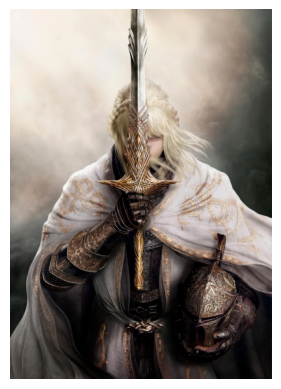

In [18]:
import matplotlib.pyplot as plt

plt.imshow(result_img)
plt.axis('off')
plt.show()

result_img = Image.fromarray(result_img)
result_img.save(f"octave.jpg")